# Evaluating docker image libraries embedding : Predicting image size

This notebook simply evaluates the quality of a library embedding by trying to estimate docker image size using the sum of the embedding of it's libraries.

It expects the swivel embedding to be accessible in a `./swivel_data` folder, and the result of dockerhub_crawler to be accessible in a `./packages` folder.

The model is a simple keras MLP. 

In [2]:
import pandas as pd
em = pd.read_csv("./swivel_input/row_embedding.tsv", sep="\t", index_col=0, header=None)
em.dropna()
em.head()

In [2]:
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [3]:
packages_list = !find packages -type f
import json
def get_images_libs():
    for path in packages_list:
        package_name = path[13:]
        with open(path) as json_file:
            try:
                package = json.load(json_file)
                libs = []
                libs += [natpack[0] for natpack in package["packages"]["native"]]
                libs += [natpack[0] for natpack in package["packages"]["python3"]]
                libs += [natpack[0] for natpack in package["packages"]["node"]]
                image = {"name": package['image'], "distro": package['distribution'], "size": package["size"], "libs": libs}
                yield image
            except Exception as e:
                #print(e)
                pass

In [4]:
from tqdm import tqdm
images_libs = [image for image in tqdm(get_images_libs())]

31754it [00:26, 1201.49it/s]


In [5]:
len(images_libs)

31754

In [9]:
libs = !cat ./swivel_input/row_vocab.txt

In [10]:
def train_test_split(images_libs, ratio=0.2):
    test_libs = set(libs[-int(len(libs)*ratio):])
    train_images = []
    test_images = []
    for image in images_libs:
        if set(image['libs']) & test_libs:
            test_images.append(image)
        else:
            train_images.append(image)
    return train_images, test_images

In [11]:
train, test = train_test_split(images_libs)

In [12]:
print(len(train), len(test))

26913 4841


In [17]:
import numpy as np
def assign_library_vectors(images):
    count = 0
    for image in tqdm(images):
        count += 1
        try:
            if image['libs']:
                vectors = [em.loc[lib].values for lib in image['libs']]
                image['embedding'] = np.array(vectors).sum(axis=0)
        except Exception as e:
            pass

In [18]:
assign_library_vectors(train)
assign_library_vectors(test)

100%|██████████| 4841/4841 [03:40<00:00, 21.99it/s]


In [19]:
test = pd.DataFrame(test)
train = pd.DataFrame(train)
test = test.dropna()
train = train.dropna()
test_save = test
train_save = train
train.head()

,distro,embedding,libs,name,size
0,debian,"[-7.839175713799998, 2.7418583072000002, -9.99...","[acl, adduser, apt, base-files, base-passwd, b...",bponath/mynginx:latest,200660
1,alpine,"[-2.721304268, 0.740504955, -1.223789856, 0.21...","[musl, busybox, alpine-baselayout, alpine-keys...",bpatel13/myfirstapp:latest,69148
2,alpine,"[-1.205533039496001, -2.943969285500004, 8.332...","[musl, busybox, alpine-baselayout, alpine-keys...",bpedazur/test-node:latest,75340
3,debian,"[-19.06419646490499, 4.000540141947999, -7.691...","[acl, adduser, apt, autoconf, automake, autoto...",bpapman/catnip:latest,732660
4,debian,"[-33.137244885105005, 3.6853197113479976, -3.0...","[acl, adduser, apt, base-files, base-passwd, b...",bpkp/jenkins:latest,802016


In [20]:
train = train[train.apply(lambda x: len(x['libs']) != 0, axis=1)]
test = test[test.apply(lambda x: len(x['libs']) != 0, axis=1)]
train.head()

,distro,embedding,libs,name,size
0,debian,"[-7.839175713799998, 2.7418583072000002, -9.99...","[acl, adduser, apt, base-files, base-passwd, b...",bponath/mynginx:latest,200660
1,alpine,"[-2.721304268, 0.740504955, -1.223789856, 0.21...","[musl, busybox, alpine-baselayout, alpine-keys...",bpatel13/myfirstapp:latest,69148
2,alpine,"[-1.205533039496001, -2.943969285500004, 8.332...","[musl, busybox, alpine-baselayout, alpine-keys...",bpedazur/test-node:latest,75340
3,debian,"[-19.06419646490499, 4.000540141947999, -7.691...","[acl, adduser, apt, autoconf, automake, autoto...",bpapman/catnip:latest,732660
4,debian,"[-33.137244885105005, 3.6853197113479976, -3.0...","[acl, adduser, apt, base-files, base-passwd, b...",bpkp/jenkins:latest,802016


In [21]:
print(train.info(), test.info())
train.size.mean()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18619 entries, 0 to 26911
Data columns (total 5 columns):
distro       18619 non-null object
embedding    18619 non-null object
libs         18619 non-null object
name         18619 non-null object
size         18619 non-null int64
dtypes: int64(1), object(4)
memory usage: 872.8+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 985 entries, 15 to 4839
Data columns (total 5 columns):
distro       985 non-null object
embedding    985 non-null object
libs         985 non-null object
name         985 non-null object
size         985 non-null int64
dtypes: int64(1), object(4)
memory usage: 46.2+ KB
None None


93095.0

Creating Features and targets

In [42]:
y_train = train['size'].values.reshape(-1, 1)
max_size = y_train.max()*1.1
y_train = y_train/max_size
X_train = np.stack(train['embedding'].values)
X_max = X_train.max()
X_train = X_train/X_max
y_test = test['size'].values.reshape(-1, 1)
y_test = y_test/max_size
X_test = np.stack(test['embedding'].values)/X_max
X_test

array([[-0.00098835,  0.00244799, -0.01384836, ..., -0.00337004,
        -0.00034843, -0.00088475],
       [-0.00181555,  0.00373144,  0.00159341, ...,  0.00012278,
         0.00184643, -0.00159609],
       [-0.00187171, -0.00338608, -0.0125162 , ..., -0.00259379,
         0.00021493,  0.00137656],
       ...,
       [-0.00798384,  0.00263064, -0.0007785 , ..., -0.00010017,
        -0.00085971,  0.00073113],
       [-0.00388552, -0.00010428,  0.0017658 , ...,  0.00313161,
        -0.0019854 ,  0.00102732],
       [-0.00283467, -0.00383671, -0.01967746, ..., -0.00445934,
         0.00028008,  0.00106391]])

In [43]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers

sgd = optimizers.SGD()

regmodel = Sequential([
    Dense(100, input_shape=(300,)),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(1,  activation="linear"),
])

regmodel.compile(optimizer=sgd, loss='mean_squared_error', metrics=["mae"])
regmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 100)               30100     
_________________________________________________________________
activation_9 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               10100     
_________________________________________________________________
activation_10 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 101       
Total params: 40,301
Trainable params: 40,301
Non-trainable params: 0
_________________________________________________________________


In [44]:
history = regmodel.fit(X_train, y_train, validation_split=0.2, epochs=300)

Train on 14895 samples, validate on 3724 samples
Epoch 1/300
14895/14895 [==============================] - 1s 86us/step - loss: 0.0011 - mean_absolute_error: 0.0138 - val_loss: 8.8763e-04 - val_mean_absolute_error: 0.0134
Epoch 2/300
14895/14895 [==============================] - 1s 63us/step - loss: 9.4925e-04 - mean_absolute_error: 0.0125 - val_loss: 8.2254e-04 - val_mean_absolute_error: 0.0125
Epoch 3/300
14895/14895 [==============================] - 1s 63us/step - loss: 9.0869e-04 - mean_absolute_error: 0.0121 - val_loss: 7.9120e-04 - val_mean_absolute_error: 0.0113
Epoch 4/300
14895/14895 [==============================] - 1s 66us/step - loss: 8.8409e-04 - mean_absolute_error: 0.0117 - val_loss: 7.6301e-04 - val_mean_absolute_error: 0.0113
Epoch 5/300
14895/14895 [==============================] - 1s 86us/step - loss: 8.5925e-04 - mean_absolute_error: 0.0112 - val_loss: 7.3344e-04 - val_mean_absolute_error: 0.0120
Epoch 6/300
14895/14895 [==============================] - 1s 73u

Epoch 92/300
14895/14895 [==============================] - 1s 79us/step - loss: 7.4348e-04 - mean_absolute_error: 0.0094 - val_loss: 6.0094e-04 - val_mean_absolute_error: 0.0098
Epoch 93/300
14895/14895 [==============================] - 1s 64us/step - loss: 7.4399e-04 - mean_absolute_error: 0.0094 - val_loss: 6.0049e-04 - val_mean_absolute_error: 0.0097
Epoch 94/300
14895/14895 [==============================] - 2s 103us/step - loss: 7.4375e-04 - mean_absolute_error: 0.0094 - val_loss: 6.0136e-04 - val_mean_absolute_error: 0.0089
Epoch 95/300
14895/14895 [==============================] - 2s 102us/step - loss: 7.4355e-04 - mean_absolute_error: 0.0093 - val_loss: 6.0129e-04 - val_mean_absolute_error: 0.0101
Epoch 96/300
14895/14895 [==============================] - 1s 70us/step - loss: 7.4357e-04 - mean_absolute_error: 0.0094 - val_loss: 5.9967e-04 - val_mean_absolute_error: 0.0096
Epoch 97/300
14895/14895 [==============================] - 1s 70us/step - loss: 7.4340e-04 - mean_abso

14895/14895 [==============================] - 1s 65us/step - loss: 7.3337e-04 - mean_absolute_error: 0.0091 - val_loss: 5.8595e-04 - val_mean_absolute_error: 0.0090
Epoch 183/300
14895/14895 [==============================] - 1s 71us/step - loss: 7.3285e-04 - mean_absolute_error: 0.0091 - val_loss: 5.8589e-04 - val_mean_absolute_error: 0.0093
Epoch 184/300
14895/14895 [==============================] - 1s 75us/step - loss: 7.3225e-04 - mean_absolute_error: 0.0091 - val_loss: 5.8647e-04 - val_mean_absolute_error: 0.0096
Epoch 185/300
14895/14895 [==============================] - 1s 72us/step - loss: 7.3246e-04 - mean_absolute_error: 0.0091 - val_loss: 5.8685e-04 - val_mean_absolute_error: 0.0086
Epoch 186/300
14895/14895 [==============================] - 1s 82us/step - loss: 7.3264e-04 - mean_absolute_error: 0.0090 - val_loss: 5.8634e-04 - val_mean_absolute_error: 0.0097
Epoch 187/300
14895/14895 [==============================] - 1s 70us/step - loss: 7.3235e-04 - mean_absolute_error

14895/14895 [==============================] - 1s 74us/step - loss: 7.2469e-04 - mean_absolute_error: 0.0089 - val_loss: 5.7385e-04 - val_mean_absolute_error: 0.0086
Epoch 273/300
14895/14895 [==============================] - 1s 76us/step - loss: 7.2393e-04 - mean_absolute_error: 0.0089 - val_loss: 5.7380e-04 - val_mean_absolute_error: 0.0085
Epoch 274/300
14895/14895 [==============================] - 1s 78us/step - loss: 7.2445e-04 - mean_absolute_error: 0.0089 - val_loss: 5.7431e-04 - val_mean_absolute_error: 0.0084
Epoch 275/300
14895/14895 [==============================] - 1s 80us/step - loss: 7.2413e-04 - mean_absolute_error: 0.0088 - val_loss: 5.7459e-04 - val_mean_absolute_error: 0.0084
Epoch 276/300
14895/14895 [==============================] - 1s 90us/step - loss: 7.2436e-04 - mean_absolute_error: 0.0088 - val_loss: 5.7340e-04 - val_mean_absolute_error: 0.0091
Epoch 277/300
14895/14895 [==============================] - 2s 132us/step - loss: 7.2399e-04 - mean_absolute_erro

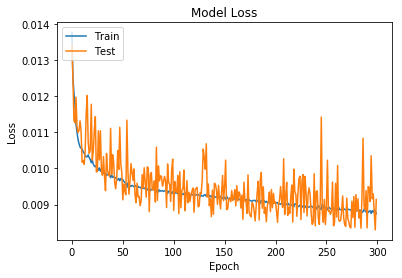

In [45]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

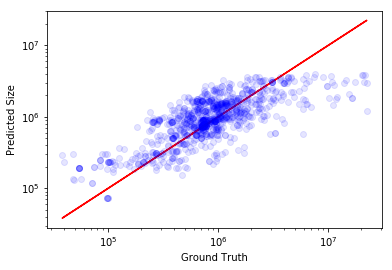

In [46]:
from matplotlib.scale import LogScale
y_test_pred = regmodel.predict(X_test)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.plot(y_test*max_size, y_test*max_size, c="red")
ax.plot(y_test*max_size, y_test_pred*max_size, 'o', c='blue', alpha=0.1,)
plt.ylabel('Predicted Size')
plt.xlabel('Ground Truth')
plt.show()

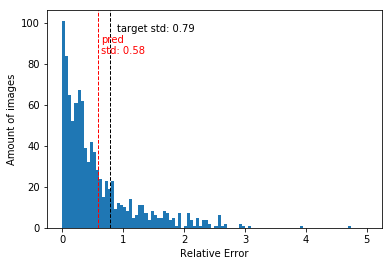

In [47]:
rel = np.abs((y_test_pred - y_test)/y_test)
std = np.abs((y_test - y_train.mean())/y_test).mean()
plt.hist(rel, bins=100, range=(0, 5))
plt.ylabel('Amount of images')
plt.xlabel('Relative Error')
_, max_ = plt.ylim()
plt.axvline(std, color='black', linestyle='dashed', linewidth=1)
plt.axvline(rel.mean(), color='red', linestyle='dashed', linewidth=1)
plt.text(rel.mean() + rel.mean()/10, 
         max_ - 2*max_/10, 
         'pred\nstd: {:.2f}'.format(rel.mean()), color='red')
plt.text(std  + 2*rel.mean()/10, 
         max_ - max_/10, 
         'target std: {:.2f}'.format(std) )
plt.show()